In [1]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver

Populating the interactive namespace from numpy and matplotlib


# Generate motors

In [95]:
n_motors = 10000
motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(-1000,1000)).trs() * 
           vsr.Rot(vsr.Biv(*np.random.random(3)).unit() * np.random.uniform(-pi, pi) * -0.5)) for i in range(n_motors)]

In [26]:
n_motors = 1000
motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(-1000,1000)).trs() * 
           vsr.Rot(vsr.Biv(*np.random.random(3)).unit() * (pi))) for i in range(n_motors)]

# Estimate motors from point observations

In [88]:
n_points=10
points_a = [vsr.Vec(*np.random.uniform(-100,100,3)).null() for i in range(n_points)]
points_b = [[point.spin(motor) for point in points_a] for motor in motors]

In [89]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
norms = []
summaries = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(points_a, points_b[i]):
        mes.add_point_correspondences_residual_block(a,b)
#     mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
    mes.set_parameterization('CAYLEY')
#     mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
    if norm > 1.00001:
        print(norm)
#     print(summary['full_report'])
    summaries.append(summary)
    norms.append(norm)

In [90]:
costs = [pd.DataFrame(summary['iterations'])['cost'] for summary in summaries]
iteration_counts = [len(cost) for cost in costs]
print('max: ', np.argmax(iteration_counts))
plt.semilogy(costs[np.argmin(iteration_counts)])

max:  6491


In [8]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
summaries = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(points_a, points_b[i]):
        mes.add_point_correspondences_residual_block(a,b)
#     mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
#     mes.num_linear_solver_threads = 2000
#     mes.num_threads = 2000
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.3.3)-lapack-suitesparse-(4.5.4)-cxsparse-(3.1.9)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC           

# Estimate motors from point observations

In [96]:
n_lines = 10

In [97]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.random(3)).null(), 
                   vsr.Vec(*np.random.random(3)).unit()).unit() for i in range(n_lines)]

In [98]:
lines_b = [[line.spin(motor) for line in lines_a] for motor in motors]

In [104]:
# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
initial_motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * 0.01)
norms = []
wrong_motors = []
summaries = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
#     for a, b in zip(points_a, points_b[i]):
#         mes.add_point_correspondences_residual_block(a,b)
    for a, b in zip(lines_a, lines_b[i]):
#         mes.add_line_commutator_residual_block(a,b)
#         mes.add_line_correspondences_residual_block(a,b)
        mes.add_line_angle_distance_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations = 50
#     mes.function_tolerance = 1e-3
    mes.parameter_tolerance = 1e-4
    (estimated_motor, summary, _) = mes.solve()
#     print(summary['brief_report'])
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
    if norm > 1.0000001:
        wrong_motors.append((motors[i], estimated_motor))
#         print(i)
#         print(norm)
#         print(summary['brief_report'])
        norms.append(norm)
    else:
        summaries.append(summary)
print(len(norms))

87


max:  2873


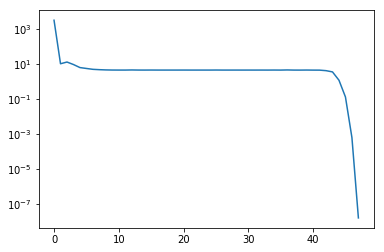

In [103]:
costs = [pd.DataFrame(summary['iterations'])['cost'] for summary in summaries]
iteration_counts = [len(cost) for cost in costs]
print('max: ', np.argmax(iteration_counts))
plt.semilogy(costs[np.argmax(iteration_counts)])

In [100]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm()) for wrong_motor in wrong_motors[:] ])

array([[   3.1112,  475.3062],
       [   3.1233,  804.3874],
       [   0.0468,  555.3367],
       [   0.0568,  534.6018],
       [   0.0651,  466.8123],
       [   3.0307,  941.5743],
       [   3.1146,  408.3005],
       [   0.0528,  728.7753],
       [   0.0124,  966.1086],
       [   0.0001,  943.1516],
       [   0.0811,  828.2628],
       [   3.0931,  729.954 ],
       [   0.0113,  362.5103],
       [   0.0461,  780.6607],
       [   3.1204,  648.9185],
       [   0.0216,  632.3127],
       [   3.0923,  420.5058],
       [   0.0406,  730.0304],
       [   3.141 ,  735.7321],
       [   0.0392,  786.423 ],
       [   3.0837,  359.7389],
       [   0.0332,  500.8488],
       [   2.9492,  581.7126],
       [   3.1345,  498.914 ],
       [   3.1389,  228.5395],
       [   3.1145,  253.5387],
       [   3.1287,  761.0213],
       [   3.1273,  350.0798],
       [   3.1294,  577.6958],
       [   0.1019,  808.7996],
       [   0.0102,  418.3004],
       [   3.0279,  674.6428],
       [

In [15]:
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.3.3)-lapack-suitesparse-(4.5.4)-cxsparse-(3.1.9)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC           

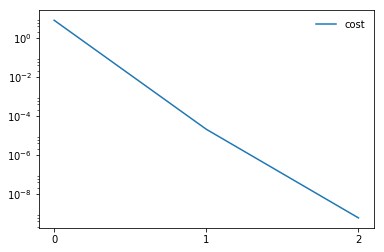

In [16]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary['iterations'])['cost'])

ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [55]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())
    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [56]:
wrong_motors = []
norms = []
for i in range(n_motors):
    estimated_motor = daniilidis_motor(lines_a, lines_b[i])
    norm = np.abs(np.linalg.norm(motors[i].rev() * estimated_motor))
    if norm > 1.000001:
        wrong_motors.append((motors[i], estimated_motor, norm))
        norms.append(norm)
print(len(norms))

0


In [57]:
wrong_motors = []
norms = []
for i in range(n_motors):
    vd = VDMotorEstimationSolver()
    vd.add_dual_line_observations(lines_a,lines_b[i])
    estimated_motor = vd.solve()
    print(estimated_motor.rot())
    print(motors[i].rot())
    norm = np.abs(np.linalg.norm(motors[i].rev() * estimated_motor))
    if norm > 1.000001:
        wrong_motors.append((motors[i].rot(), estimated_motor.rot(), norm))
        norms.append(norm)
print(len(norms))


Rot: [ -0.99 0.14 0.091 0.036 ]
Rot: [ 0.99 -0.14 -0.091 -0.036 ]
Rot: [ -1 0.072 0.06 0.024 ]
Rot: [ 1 -0.072 -0.06 -0.024 ]
Rot: [ 0.71 0.37 0.25 0.55 ]
Rot: [ 0.71 0.37 0.25 0.55 ]
Rot: [ -0.76 0.21 0.61 0.12 ]
Rot: [ 0.76 -0.21 -0.61 -0.12 ]
Rot: [ -0.88 0.26 0.31 0.25 ]
Rot: [ 0.88 -0.26 -0.31 -0.25 ]
Rot: [ 0.99 0.076 0.014 0.12 ]
Rot: [ 0.99 0.076 0.014 0.12 ]
Rot: [ -0.84 0.41 0.32 0.16 ]
Rot: [ 0.84 -0.41 -0.32 -0.16 ]
Rot: [ -0.88 0.39 0.27 0.017 ]
Rot: [ 0.88 -0.39 -0.27 -0.017 ]
Rot: [ -0.44 -0.65 -0.58 -0.19 ]
Rot: [ 0.44 0.65 0.58 0.19 ]
Rot: [ -0.13 -0.68 -0.6 -0.4 ]
Rot: [ 0.13 0.68 0.6 0.4 ]
Rot: [ 0.99 0.14 0.1 0.012 ]
Rot: [ 0.99 0.14 0.1 0.012 ]
Rot: [ 0.38 -0.1 -0.85 -0.36 ]
Rot: [ 0.38 -0.1 -0.85 -0.36 ]
Rot: [ 0.8 0.56 0.21 0.045 ]
Rot: [ 0.8 0.56 0.21 0.045 ]
Rot: [ -0.98 -0.039 -0.16 -0.1 ]
Rot: [ 0.98 0.039 0.16 0.1 ]
Rot: [ -0.89 0.39 0.18 0.16 ]
Rot: [ 0.89 -0.39 -0.18 -0.16 ]
Rot: [ 0.46 -0.85 -0.24 -0.00099 ]
Rot: [ 0.46 -0.85 -0.24 -0.00099 ]
Rot: [ -0.26

In [58]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm(), wrong_motor[2]) for wrong_motor in wrong_motors[:] ])

AttributeError: 'versor_pybind11.Rot' object has no attribute 'rot'

In [ ]:
norms

In [ ]:
def gauss_newton(lines_a, lines_b, initial_motor=vsr.Mot(1,0,0,0,0,0,0,0), max_iterations=10):
    Jci = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M))).comm(l2)) * 2
    fci = lambda M, l1, l2 : np.array(l1.spin(M).comm(l2)).reshape(6,1)
    M = initial_motor
    eps1 = 1e-6
    eps2 = 1e-6
    rsc = []
    for i in range(max_iterations):
        k = len(rsc)
        Jc = np.array([np.array([Jci(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                             vsr.Dll(0,1,0,0,0,0),
                                                             vsr.Dll(0,0,1,0,0,0),
                                                             vsr.Dll(0,0,0,1,0,0),
                                                             vsr.Dll(0,0,0,0,1,0),
                                                             vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                    for a, b in zip(lines_a, lines_b) ]).reshape(-1,6)
    #     print(Jc)
        fc = np.array([fci(M,a,b) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
        A = np.dot(Jc.T,Jc)
        g = np.dot(Jc.T, fc)
        r = np.dot(fc.T,fc)[0][0] / 2
        rsc.append(r)
        if r < 1e-6:
            break
        h = np.dot(np.linalg.pinv(A), -g)
    #     h = -g
        B = vsr.Dll(*h)
        M = B.exp() * M
    return M

# Planes

In [ ]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = vsr.Vec(*np.random.random(3)).unit()
    distance = np.random.uniform(-1000,1000)
    planes_a.append(vsr.Dlp(dir_vec,distance))
planes_b = [[plane.spin(motor) for plane in planes_a] for motor in motors]

In [60]:
len(planes_b)

10000

In [61]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
norms = []
wrong_motors = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b[i]):
#         mes.add_dual_plane_commutator_residual_block(a,b)
#         mes.add_dual_plane_angle_error_residual_block(a,b)
        mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations = 50
    mes.parameter_tolerance = 1e-7
    (estimated_motor, summary, _) = mes.solve()
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
    if norm > 1.000001:
        wrong_motors.append((motors[i], estimated_motor))
    else:
        
        norms.append(norm)
print(len(norms))

0


In [62]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm()) for wrong_motor in wrong_motors[:] ])

array([], dtype=float64)

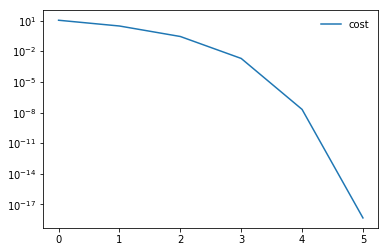

In [63]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary['iterations'])['cost'])

ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [64]:
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.3.3)-lapack-suitesparse-(4.5.4)-cxsparse-(3.1.9)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC           